<a href="https://colab.research.google.com/github/neelabhtiwari/Portfolio-Optimisation-using-Reinforcement-Learning-Algorithms/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from agent import Agent
# from functions import *
from agent import Agent 
# from functions import *
# import sys
import pandas as pd
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
import math
import numpy as np
import random
from collections import deque

# if len(sys.argv) != 4:
# 	print("Usage: python train.py [stock] [window] [episodes]")
# 	exit()


def formatPrice(n):
	return ("₹" if n < 0 else "₹") + "{0:.2f}".format(abs(n))

def getStockDataVec(key):
	vec = []
	lines = open(key + ".csv", "r").read().splitlines()

	for line in lines[1:]:
		if str(line.split(",")[5]) == "null":
			continue
		vec.append(float(line.split(",")[5]))
	return vec

def sigmoid(x):
	return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
	d = t - n + 1
	block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
	res = []
	for i in range(n - 1):
		res.append(sigmoid(block[i + 1] - block[i]))

	return np.array([res])




# stock_name, window_size, episode_count = sys.argv[1], float(sys.argv[2]), int(sys.argv[3])
window_size = 10
stock_name = "SBIN_train"
episode_count = 200
# test_size=3000
agent = Agent(window_size)
data = getStockDataVec(stock_name)
# data = pd.read_csv("^GSPC.csv")
l = len(data) - 1
batch_size = 16


for e in range(episode_count + 1):
	print("Episode " + str(e) + "/" + str(episode_count))
	state = getState(data, 0, window_size + 1)

	total_profit = 0
	agent.inventory = []

	for t in range(l):
		action = agent.act(state)

		# sit
		next_state = getState(data, t + 1, window_size + 1)
		reward = 0

		if action == 1: # buy
			agent.inventory.append(data[t])
			print("Buy: " + formatPrice(data[t]))

		elif action == 2 and len(agent.inventory) > 0: # sell
			bought_price = agent.inventory.pop(0)
			reward = max(data[t] - bought_price, 0)
			total_profit += data[t] - bought_price
			print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

		done = True if t == l - 1 else False
		agent.memory.append((state, action, reward, next_state, done))
		state = next_state

		if done:
			print("--------------------------------")
			print("Total Profit: " + formatPrice(total_profit))
			print("--------------------------------")

		if len(agent.memory) > batch_size:
			agent.expReplay(batch_size)

	if e % 10 == 0:
		agent.model.save("models/model_ep" + str(e))

In [ ]:
#############EVALUATE ON TEST SET#######################

In [ ]:
  # from agent import Agent
  # from functions import *
  from agent import Agent 
  # from functions import *
  import sys
  import pandas as pd
  import keras
  from keras.models import Sequential
  from keras.models import load_model
  from keras.layers import Dense
  from keras.optimizers import Adam
  import math
  import numpy as np
  import random
  from collections import deque

  def formatPrice(n):
	  return ("₹" if n < 0 else "₹") + "{0:.2f}".format(abs(n))


  def sigmoid(x):
	  return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
	d = t - n + 1
	block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
	res = []
	for i in range(n - 1):
		res.append(sigmoid(block[i + 1] - block[i]))

	return np.array([res])

  def getStockDataVec(key):
      vec = []
      lines = open(key + ".csv", "r").read().splitlines()

      for line in lines[1:]:
        if str(line.split(",")[5]) == "null":
          continue
        vec.append(float(line.split(",")[5]))
      return vec

  # import keras
  # from keras.models import load_model

  # from agent import Agent
  # # from functions import *
  # import sys

  # if len(sys.argv) != 3:
  # 	print "Usage: python evaluate.py [stock] [model]"
  # 	exit()

  # stock_name, model_name = sys.argv[1], sys.argv[2]
  model_name = "model_ep0"
  model = load_model("models/" + model_name)
  window_size = model.layers[0].input.shape.as_list()[1]

  agent = Agent(window_size, True, model_name)
  stock_name_test = "RELIANCE_test"
  data = getStockDataVec(stock_name_test)
  l = len(data) - 1
  batch_size = 16
  buy_arr = np.zeros((l,1))
  sell_arr = np.zeros((l,1))

  state = getState(data, 0, window_size + 1)
  total_profit = 0
  agent.inventory = []

  for t in range(l):
    action = agent.act(state)

    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0

    if action == 1: # buy
      buy_arr[t] = data[t]
      agent.inventory.append(data[t])
      print("Buy: " + formatPrice(data[t]))

    elif action == 2 and len(agent.inventory) > 0: # sell
      sell_arr[t] = data[t]
      bought_price = agent.inventory.pop(0)
      reward = max(data[t] - bought_price, 0)
      total_profit += data[t] - bought_price
      print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
      

    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
      print("--------------------------------")
      print(stock_name_test + " Total Profit: " + formatPrice(total_profit))
      print("--------------------------------")


Buy: ₹913.77
Buy: ₹909.03
Sell: ₹920.49 | Profit: ₹6.72
Sell: ₹960.23 | Profit: ₹51.20
Buy: ₹954.69
Sell: ₹953.31 | Profit: ₹1.38
Buy: ₹893.86
Buy: ₹891.68
Buy: ₹881.75
Sell: ₹884.02 | Profit: ₹9.83
Sell: ₹894.05 | Profit: ₹2.37
Sell: ₹887.43 | Profit: ₹5.68
Buy: ₹918.57
Sell: ₹913.63 | Profit: ₹4.94
Buy: ₹939.47
Sell: ₹943.47 | Profit: ₹4.00
Buy: ₹913.38
Buy: ₹900.28
Buy: ₹879.43
Sell: ₹900.87 | Profit: ₹12.50
Sell: ₹902.51 | Profit: ₹2.22
Sell: ₹919.51 | Profit: ₹40.08
Buy: ₹918.27
Sell: ₹901.22 | Profit: ₹17.05
Buy: ₹886.49
Sell: ₹897.61 | Profit: ₹11.12
Buy: ₹890.64
Sell: ₹889.36 | Profit: ₹1.28
Buy: ₹897.66
Sell: ₹900.43 | Profit: ₹2.77
Buy: ₹927.96
Sell: ₹926.18 | Profit: ₹1.78
Buy: ₹931.37
Sell: ₹917.13 | Profit: ₹14.23
Buy: ₹925.14
Sell: ₹958.79 | Profit: ₹33.65
Buy: ₹959.73
Buy: ₹955.88
Sell: ₹965.37 | Profit: ₹5.63
Buy: ₹969.77
Sell: ₹977.77 | Profit: ₹21.89
Sell: ₹975.15 | Profit: ₹5.39
Buy: ₹967.59
Sell: ₹945.06 | Profit: ₹22.54
Buy: ₹916.00
Buy: ₹901.67
Sell: ₹905.22 | Pro

In [ ]:
buy_arr.size

441

In [ ]:
sell_arr.size

441

In [ ]:
import matplotlib.pyplot as plt

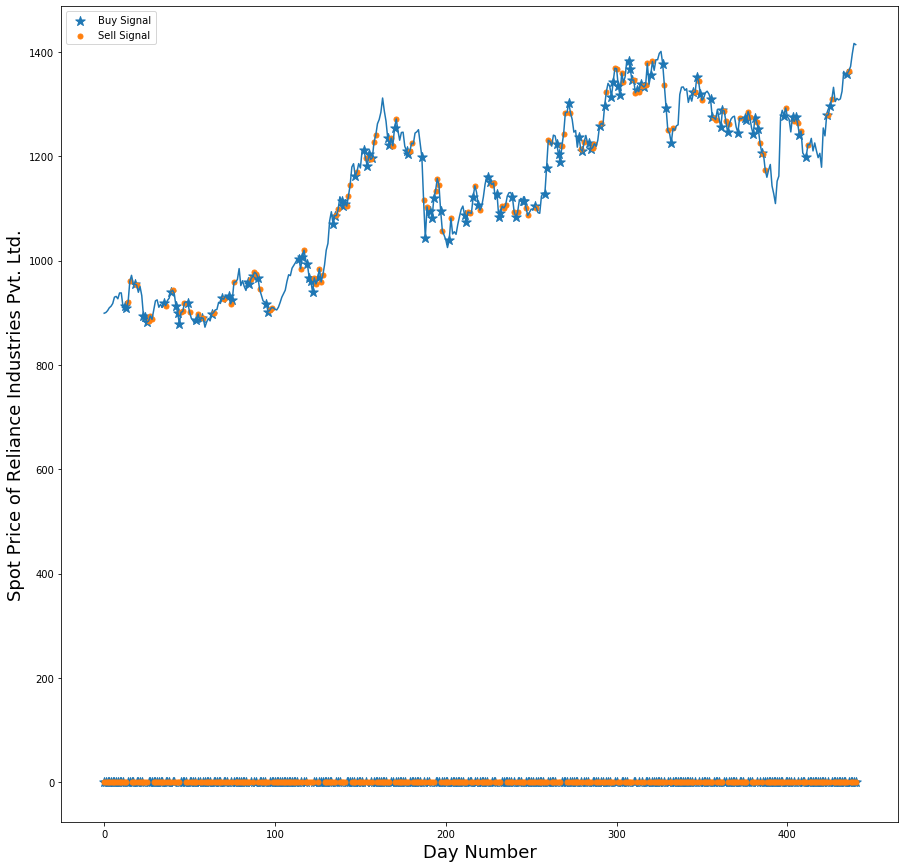

In [ ]:
stock_name_test = "RELIANCE_test"
data = getStockDataVec(stock_name_test)
arr = range(l)
plt.plot(arr,data[0:441])
plt.scatter(arr,buy_arr,marker='*',s=100,label='Buy Signal')
plt.scatter(arr,sell_arr,marker='.',s=100,label='Sell Signal')
plt.rcParams['figure.figsize'] = [15, 15]
plt.legend()
plt.xlabel('Day Number',fontsize=18)
plt.ylabel('Spot Price of Reliance Industries Pvt. Ltd.',fontsize=18)
plt.savefig('main.png')
from google.colab import files
files.download('main.png')

In [ ]:
buy_arr[buy_arr>0].size

116

In [ ]:
buy_nonzero=buy_arr[buy_arr>0]

array([ 913.773438,  909.029175,  954.693115,  893.857178,  891.6828  ,
        881.749329,  918.567139,  939.471802,  913.378052,  900.281738,
        879.426636,  918.27063 ,  886.493652,  890.644897,  897.662537,
        927.956909,  931.366882,  925.140015,  959.733887,  955.87915 ,
        969.766174,  967.591675,  915.997375,  901.665588, 1003.767029,
       1007.424072,  992.795837,  967.591675,  960.530762,  939.745911,
        965.950745, 1070.272949, 1086.334106, 1114.130249, 1104.831665,
       1109.008545, 1161.915527, 1211.24231 , 1181.158936, 1203.932861,
       1197.120605, 1234.81189 , 1222.380737, 1254.453125, 1210.446777,
       1204.082031, 1198.463135, 1043.073608, 1096.030396, 1081.809204,
       1120.345825, 1095.234863, 1039.145508, 1087.427979, 1074.052124,
       1121.191162, 1106.770996, 1161.119995, 1150.081055, 1127.555908,
       1084.245728, 1091.505493, 1122.235229, 1083.151733, 1115.074951,
       1114.826294, 1104.632813, 1128.202148, 1177.827393, 1222.

In [ ]:
import numpy as np
from PIL import Image

im = Image.open('download (2).png')
im = im.convert('RGBA')
data = np.array(im)
# just use the rgb values for comparison
rgb = data[:,:,:3]
color = [246, 213, 139]   # Original value
black = [0,0,0, 255]
white = [255,255,255,255]
mask = np.all(rgb == color, axis = -1)
# change all pixels that match color to white
data[mask] = white

# change all pixels that don't match color to black
##data[np.logical_not(mask)] = black
new_im = Image.fromarray(data)
new_im.save('download (2).png')


In [ ]:
data.size

1401600

In [ ]:
!ls

agent.py  models       RELIANCE_test.csv   sample_data
main.png  __pycache__  RELIANCE_train.csv


In [ ]:
im = Image.open('main.png')

In [ ]:
  # from agent import Agent
  # from functions import *
  from agent import Agent 
  # from functions import *
  import sys
  import pandas as pd
  import keras
  from keras.models import Sequential
  from keras.models import load_model
  from keras.layers import Dense
  from keras.optimizers import Adam
  import math
  import numpy as np
  import random
  from collections import deque

  def formatPrice(n):
	  return ("₹" if n < 0 else "₹") + "{0:.2f}".format(abs(n))


  def sigmoid(x):
	  return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
	d = t - n + 1
	block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
	res = []
	for i in range(n - 1):
		res.append(sigmoid(block[i + 1] - block[i]))

	return np.array([res])

  def getStockDataVec(key):
      vec = []
      lines = open(key + ".csv", "r").read().splitlines()

      for line in lines[1:]:
        if str(line.split(",")[5]) == "null":
          continue
        vec.append(float(line.split(",")[5]))
      return vec

  # import keras
  # from keras.models import load_model

  # from agent import Agent
  # # from functions import *
  # import sys

  # if len(sys.argv) != 3:
  # 	print "Usage: python evaluate.py [stock] [model]"
  # 	exit()

  # stock_name, model_name = sys.argv[1], sys.argv[2]
  model_name = "model_ep0"
  model = load_model("models/" + model_name)
  window_size = model.layers[0].input.shape.as_list()[1]

  agent = Agent(window_size, True, model_name)
  stock_name_test = "SBIN_test"
  data = getStockDataVec(stock_name_test)
  l = len(data) - 1
  batch_size = 8
  buy_arr = np.zeros((l,1))
  sell_arr = np.zeros((l,1))

  state = getState(data, 0, window_size + 1)
  total_profit = 0
  agent.inventory = []

  for t in range(l):
    action = agent.act(state)

    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0

    if action == 1: # buy
      buy_arr[t] = data[t]
      agent.inventory.append(data[t])
      print("Buy: " + formatPrice(data[t]))

    elif action == 2 and len(agent.inventory) > 0: # sell
      sell_arr[t] = data[t]
      bought_price = agent.inventory.pop(0)
      reward = max(data[t] - bought_price, 0)
      total_profit += data[t] - bought_price
      print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
      

    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
      print("--------------------------------")
      print(stock_name_test + " Total Profit: " + formatPrice(total_profit))
      print("--------------------------------")


Buy: ₹233.20
Buy: ₹242.60
Buy: ₹246.40
Buy: ₹241.00
Buy: ₹241.90
Buy: ₹241.95
Sell: ₹246.50 | Profit: ₹13.30
Buy: ₹250.05
Buy: ₹248.00
Buy: ₹247.95
Buy: ₹250.35
Buy: ₹253.60
Buy: ₹248.00
Buy: ₹243.10
Buy: ₹242.70
Buy: ₹238.85
Buy: ₹244.45
Buy: ₹253.90
Buy: ₹263.20
Buy: ₹268.50
Buy: ₹266.95
Sell: ₹272.05 | Profit: ₹29.45
Sell: ₹264.30 | Profit: ₹17.90
Sell: ₹267.15 | Profit: ₹26.15
Buy: ₹269.55
Buy: ₹266.70
Buy: ₹263.00
Buy: ₹263.55
Buy: ₹270.15
Buy: ₹269.65
Buy: ₹273.00
Buy: ₹274.00
Buy: ₹282.85
Sell: ₹287.70 | Profit: ₹45.80
Buy: ₹282.60
Sell: ₹277.45 | Profit: ₹35.50
Buy: ₹276.85
Buy: ₹272.60
Buy: ₹273.30
Buy: ₹268.65
Buy: ₹273.05
Buy: ₹268.45
Buy: ₹267.40
Sell: ₹261.70 | Profit: ₹11.65
Sell: ₹257.00 | Profit: ₹9.00
Sell: ₹259.35 | Profit: ₹11.40
Buy: ₹258.85
Buy: ₹257.50
Buy: ₹257.45
Buy: ₹256.45
Sell: ₹257.20 | Profit: ₹6.85
Buy: ₹261.55
Buy: ₹263.75
Buy: ₹259.10
Buy: ₹262.75
Buy: ₹257.75
Sell: ₹251.60 | Profit: ₹2.00
Buy: ₹259.05
Buy: ₹259.55
Buy: ₹260.20
Buy: ₹261.50
Buy: ₹266.35

In [ ]:
import matplotlib.pyplot as plt
stock_name_test = "SBIN_test"
data = getStockDataVec(stock_name_test)
arr = range(l)
plt.plot(arr,data[0:l])
plt.scatter(arr,buy_arr,marker='*',s=50,label='Buy Signal')
plt.scatter(arr,sell_arr,marker='.',s=50,label='Sell Signal')
plt.rcParams['figure.figsize'] = [10, 10]
plt.legend()
plt.xlabel('Day Number',fontsize=18)
plt.ylabel('Spot Price of SBI',fontsize=18)
plt.savefig('mainrel.png')
from google.colab import files
files.download('mainrel.png')

NameError: ignored

In [ ]:
stock_name_test = "SBIN_test"
data = getStockDataVec(stock_name_test)

In [ ]:
len(data)

264